In [52]:
%%bash
LD_LIBRARY_PATH=/nas/longleaf/rhel8/apps/cuda/lib64:$PATH:$LD_LIBRARY_PATH
export LD_LIBRARY_PATH
XLA_FLAGS=--xla_gpu_cuda_data_dir=/nas/longleaf/rhel8/apps/cuda/11.8
export XLA_FLAGS

In [1]:
import os

from xml.etree import ElementTree
import glob
from tensorflow import keras
import tensorflow as tf
import sklearn
from skimage import draw
from skimage.io import imread
from skimage import morphology
from skimage import transform
from skimage import util
import numpy as np
from matplotlib import pyplot
#from tensorflow import keras
#import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, Model
from tensorflow.keras.utils import  plot_model
tf.keras.backend.set_image_data_format('channels_last')
from tensorflow import keras
import random

2023-04-29 16:52:05.210086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 16:52:05.313016: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-29 16:52:05.315479: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-29 16:52:05.315489: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
tf.config.list_physical_devices('GPU')

2023-04-29 16:52:08.779466: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-29 16:52:08.779486: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-29 16:52:08.779503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Silicon-Eye): /proc/driver/nvidia/version does not exist


[]

In [3]:
et = ElementTree.parse("proboscis_annotations_big.xml")

In [4]:
image_names = sorted(glob.glob("big/*.png"))

In [5]:
masks = {}
for img in et.findall('image'):
    width = int(img.attrib['width']) + 1
    height = int(img.attrib['height']) + 1
    blank = np.zeros(shape=(height,width),dtype=np.uint8)
    polys = img.findall('polyline')
    for poly in polys:
        attribs = poly.attrib
        pstr = attribs['points']
        pairs = pstr.split(';')
        coord_list = []
        for pair in pairs:
            xstr,ystr = pair.split(',')
            x = float(xstr)
            y = float(ystr)
            coord_list.append((x,y))
        for i in range(len(coord_list) - 1):
            start = coord_list[i]
            end = coord_list[i + 1]
            line = draw.line(round(start[1]),round(start[0]),round(end[1]),round(end[0]))
            blank[line] = np.uint8(255)
    masks[img.attrib['name']] = blank > 0

In [6]:
!pip freeze | grep 'scikit-image'

scikit-image==0.19.3


In [7]:
images = {}
for name in image_names:
    data = imread(name)
    images[name] = data

In [8]:
names = [image_name[4:] for image_name in image_names]

In [9]:
pairs = []
cross = zip(image_names, image_names)
for short_name, long_name in cross:
    if short_name in masks:
        mask = masks[short_name]
        trainee = images[long_name]
        pairs.append((trainee, morphology.dilation(mask[:-1,:-1])))
    else:
        trainee = images[long_name]
        mask = np.zeros(shape=trainee.shape)
        pairs.append((trainee, mask))

In [10]:
len(pairs)

373

In [11]:
with_probs = filter(lambda pair : pair[1].sum() > 0, pairs)

In [12]:
labeled_pairs = list(with_probs)

In [13]:
len(labeled_pairs)

350

In [14]:
inputs = []
outputs = []
for my_in, my_out in labeled_pairs:
    inputs.append(my_in)
    outputs.append(my_out)

In [15]:
ins = np.array(inputs)
outs = np.array(outputs)

In [16]:
ins.shape

(350, 600, 100)

In [17]:
outs.shape

(350, 600, 100)

In [18]:
input_data = ins[..., np.newaxis]
output_data = outs[..., np.newaxis]

In [78]:
# from https://blog.paperspace.com/unet-architecture-image-segmentation/

def convolution_block(input_lay, filters=64):
    conv1 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(input_lay)
    bn1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(bn1)
    
    conv2 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(act1)
    bn2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(bn2)
    
    return act2

def encoder(input_lay, filters=64):
    enc1 = convolution_block(input_lay, filters)
    max_pool1 = layers.MaxPooling2D()(enc1)
    return enc1, max_pool1

def decoder(input_lay, skip_lay, filters=64):
    upsample = layers.Conv2DTranspose(filters, (2,2), strides=2, padding="same")(input_lay)
    connect_skip = layers.Concatenate()([upsample, skip_lay])
    out = convolution_block(connect_skip, filters)
    return out

def u_net(image_size):
    input1 = layers.Input(image_size)
    
    skip1, enc1 = encoder(input1, 64)
    skip2, enc2 = encoder(enc1, 64 * 2)
    skip3, enc3 = encoder(enc2, 64 * 4)
    skip4, enc4 = encoder(enc3, 64 * 8)
    
    conv_block = convolution_block(enc4, 64*16)
    
    dec1 = decoder(conv_block, skip4, 64 * 8)
    dec2 = decoder(dec1, skip3, 64 * 4)
    dec3 = decoder(dec2, skip2, 64 * 2)
    dec4 = decoder(dec3, skip1, 64)
    
    out = layers.Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(dec4)
    
    model = Model(input1, out)
    
    return model

inp = layers.Input(shape=[600,100,1])
res = layers.Rescaling(1.0/255)(inp)
#x = layers.Conv2D(filters=4, kernel_size=(3,3))(res)

skip1, enc1 = encoder(res, 64)
skip2, enc2 = encoder(enc1, 64 * 2)
#skip3, enc3 = encoder(enc2, 64 * 4)

conv_block = convolution_block(enc2, 64 * 4)

dec1 = decoder(conv_block, skip2, 64 * 2)
dec2 = decoder(dec1, skip1, 64)
#dec3 = decoder(dec2, skip1, 64)

f = layers.Flatten()(dec2)

#out = layers.Dense(1)(f)
out = layers.Conv2D(filters=1, kernel_size=(1,1))(dec2)

model = Model(inp, out)
model.compile(loss=losses.BinaryCrossentropy(), optimizer=optimizers.Adam(use_ema=True, weight_decay=0.1))
#plot_model(model)

In [ ]:
model.summary()

In [19]:
import math

class ImageSeq(keras.utils.Sequence):
    
    def __init__(self, ins: np.ndarray, outs: np.ndarray, batch=32):
        assert ins.shape == outs.shape
        self.inputs = np.copy(ins)
        self.outputs = np.copy(outs)
        self.batch = batch
    
    def __len__(self):
        return math.ceil(len(self.inputs) / self.batch)
    
    def __getitem__(self, idx):
        i = self.inputs[idx * self.batch : (idx + 1) * self.batch]
        o = self.outputs[idx * self.batch : (idx + 1) * self.batch]
        return i.astype(np.uint8), o
    

class RepeatSeq(keras.utils.Sequence):
    
    def __init__(self, wrapped, repeats :int):
        self.wrapped = wrapped
        self.repeats = repeats
    
    def __len__(self):
        return len(self.wrapped) * self.repeats
    
    def __getitem__(self, idx):
        rel_idx = idx % len(self.wrapped)
        i, o = self.wrapped[rel_idx]
        return np.copy(i), np.copy(o)
    
class RandomFlip(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.thresh = thresh
        self.should_flip = np.random.random(len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.should_flip[idx] > self.thresh:
            give_i = np.flip(give_i, axis=1)
            give_o = np.flip(give_o, axis=1)
        return give_i, give_o

class RandomXShift(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.move_likely = np.random.random(len(wrapped))
        self.thresh = thresh
        self.move_amount = np.random.randint(-20, 20, len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.move_likely[idx] > self.thresh:
            move = self.move_amount[idx]
            transl = transform.EuclideanTransform(translation=[move, 0])
            for j in range(len(give_i)):
                give_i[j] = util.img_as_ubyte(transform.warp(give_i[j], transl.inverse))
                give_o[j] = util.img_as_ubyte(transform.warp(give_o[j], transl.inverse))
        return give_i, give_o

class RandomYShift(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.move_likely = np.random.random(len(wrapped))
        self.thresh = thresh
        self.move_amount = np.random.randint(-200, 200, len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.move_likely[idx] > self.thresh:
            move = self.move_amount[idx]
            transl = transform.EuclideanTransform(translation=[0, move])
            for j in range(len(give_i)):
                give_i[j] = util.img_as_ubyte(transform.warp(give_i[j], transl.inverse))
                give_o[j] = util.img_as_ubyte(transform.warp(give_o[j], transl.inverse))
        return give_i, give_o

class SubsetSequence(keras.utils.Sequence):
    
    def __init__(self, sequence, subset):
        self.subset = subset
        self.sequence = sequence
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        where = self.subset[idx]
        place = self.sequence[where]
        return place

In [20]:
r = RandomXShift(RandomYShift(RandomFlip(RepeatSeq(ImageSeq(input_data, output_data, 8), 64))))

In [21]:
test_subset = set(random.sample(range(len(r)), int(0.3 * len(r))))
train_subset = set(range(len(r))).difference(test_subset)
test_subset = sorted(list(test_subset))
train_subset = sorted(list(train_subset))
train_sequence = SubsetSequence(r, train_subset)
test_sequence = SubsetSequence(r, test_subset)

In [22]:
print(len(train_sequence))
print(len(test_sequence))
print(len(r))

1972
844
2816


In [ ]:
model.fit(train_sequence, epochs=40)
model.save("proboscis_wdecay_5")

Epoch 1/40
1116/1972 [===============>..............] - ETA: 2:59 - loss: 0.0662

In [ ]:
test_results = model.evaluate(test_sequence)
print(model.metrics_names)
print(test_results)

In [28]:
model = keras.models.load_model("overtrained_1/")

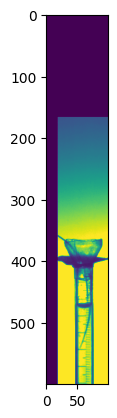

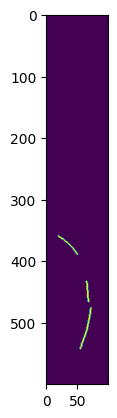

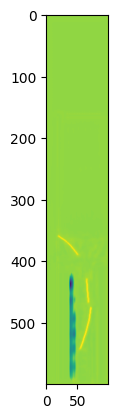

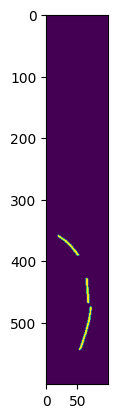

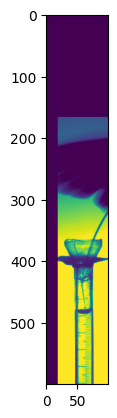

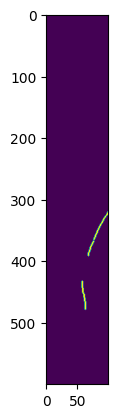

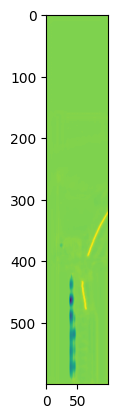

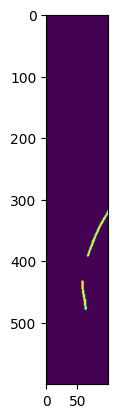

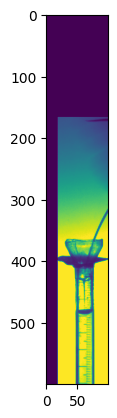

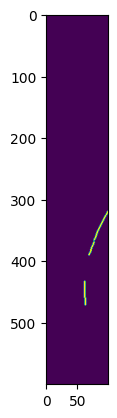

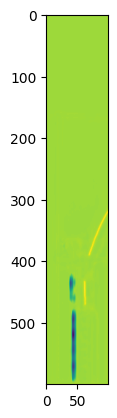

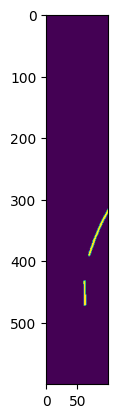

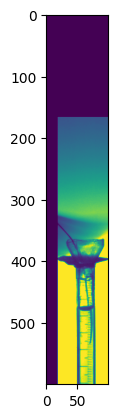

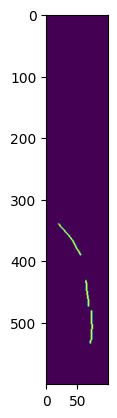

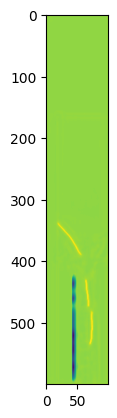

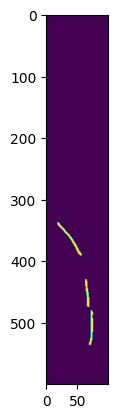

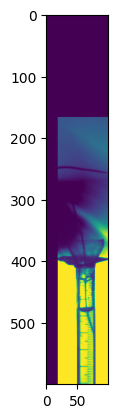

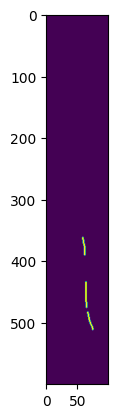

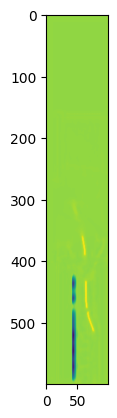

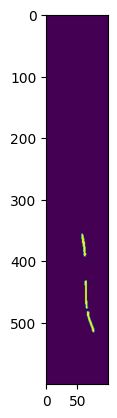

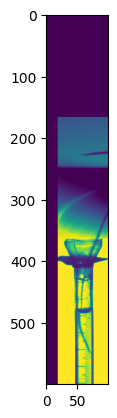

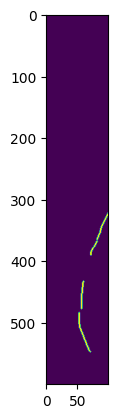

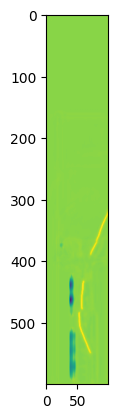

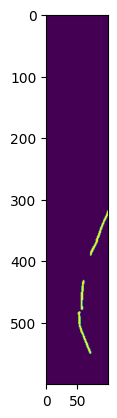

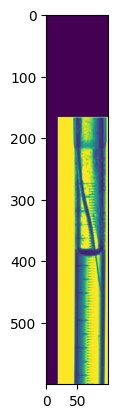

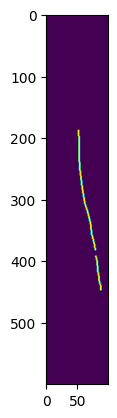

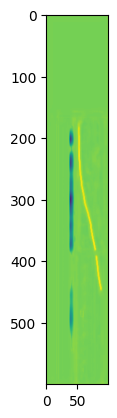

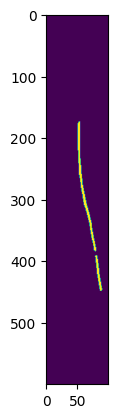

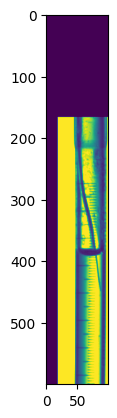

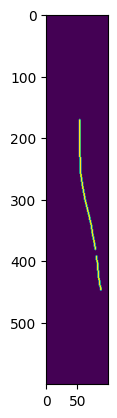

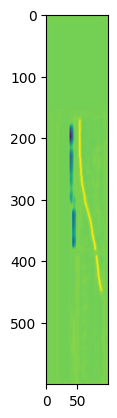

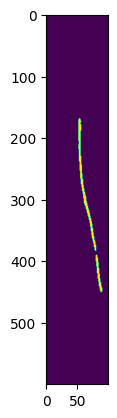

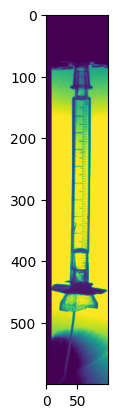

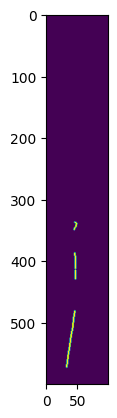

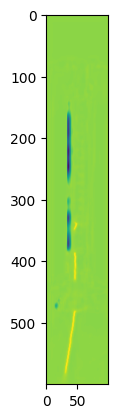

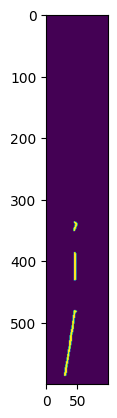

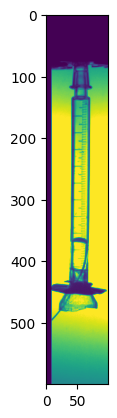

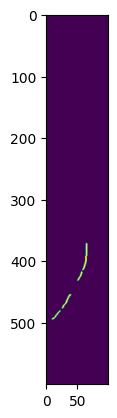

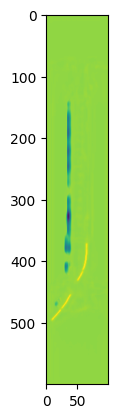

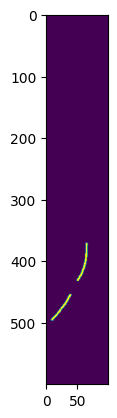

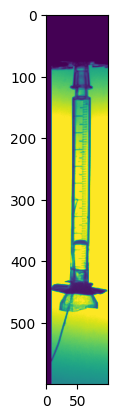

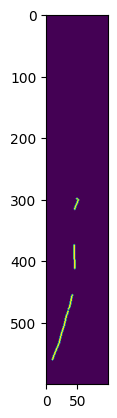

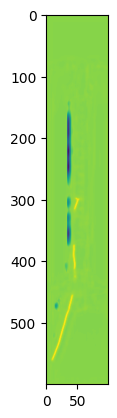

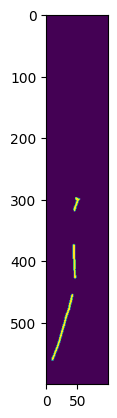

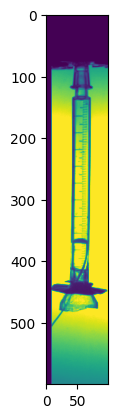

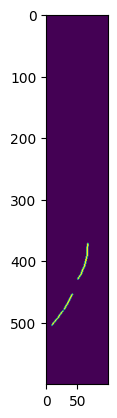

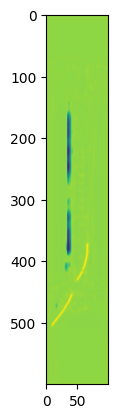

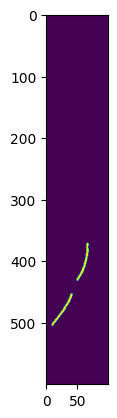

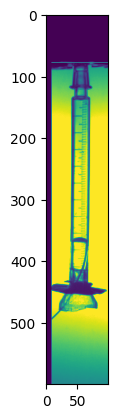

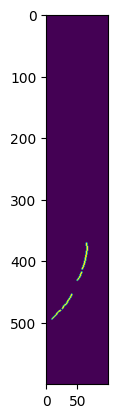

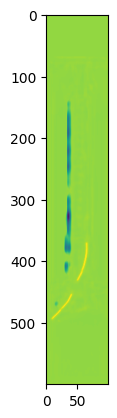

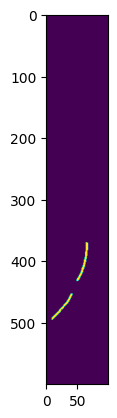

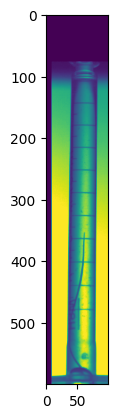

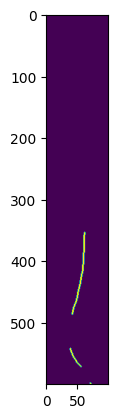

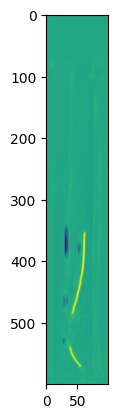

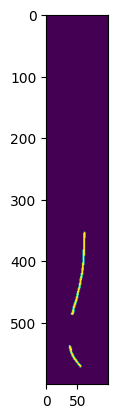

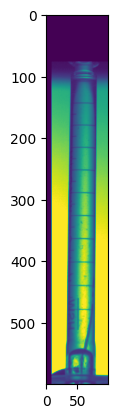

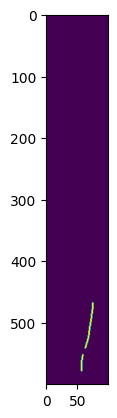

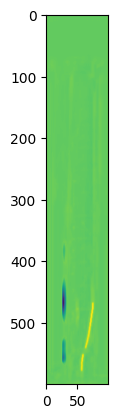

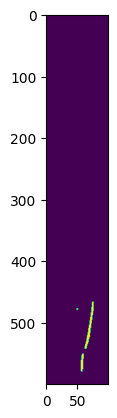

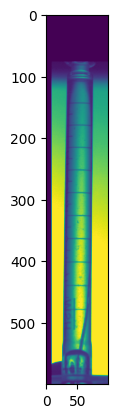

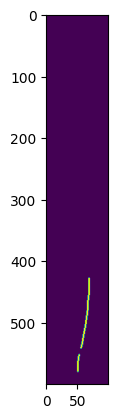

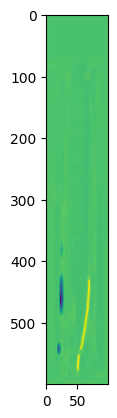

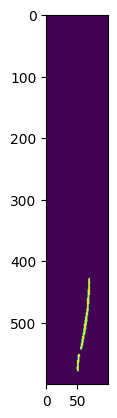

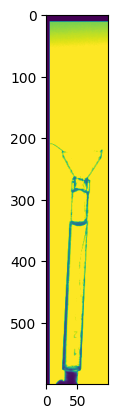

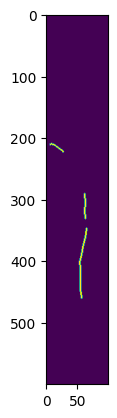

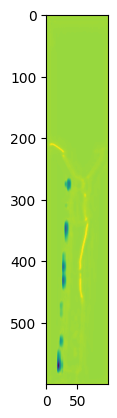

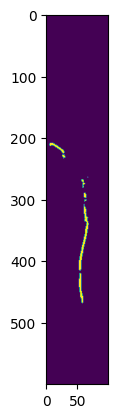

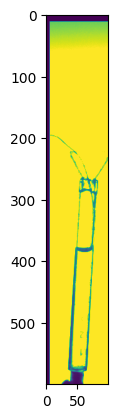

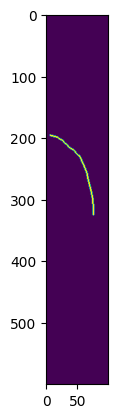

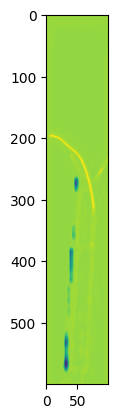

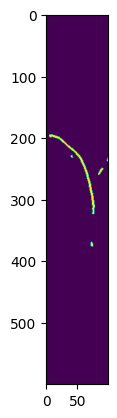

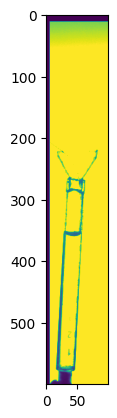

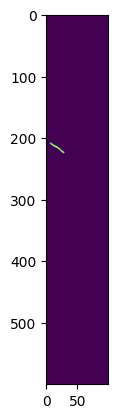

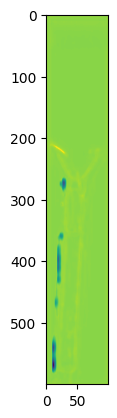

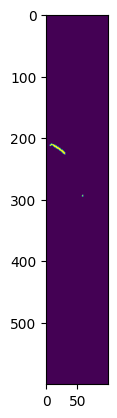

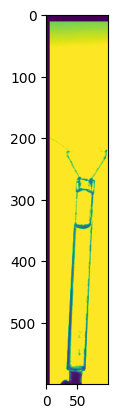

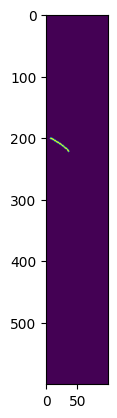

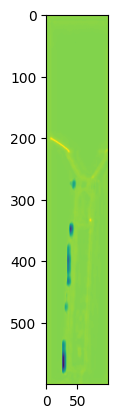

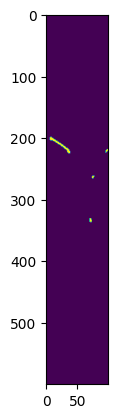

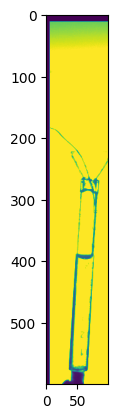

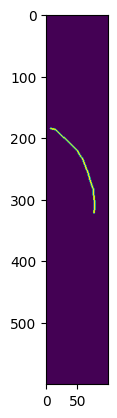

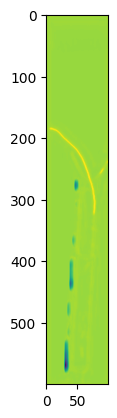

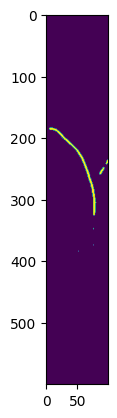

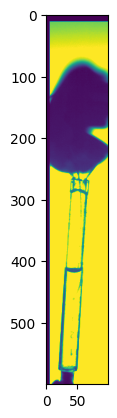

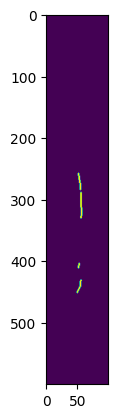

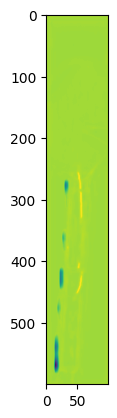

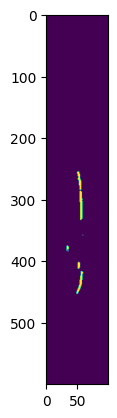

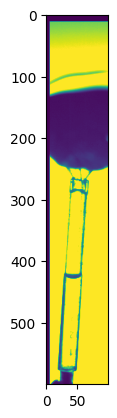

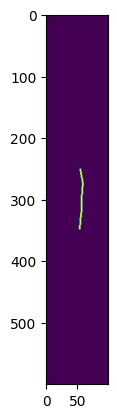

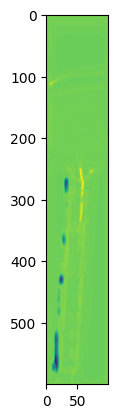

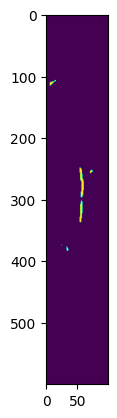

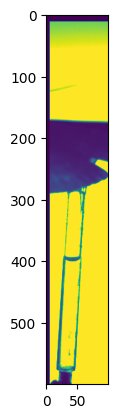

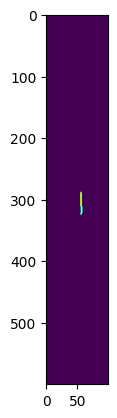

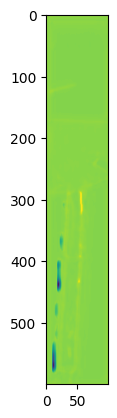

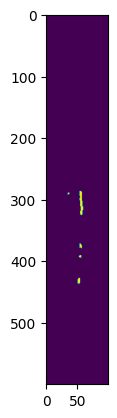

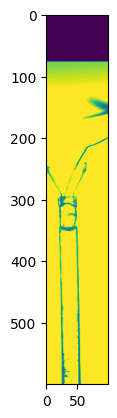

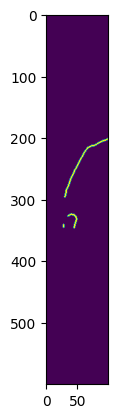

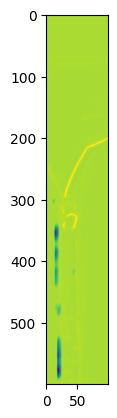

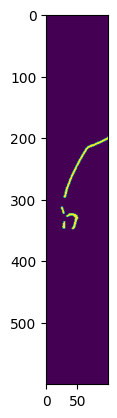

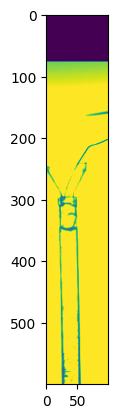

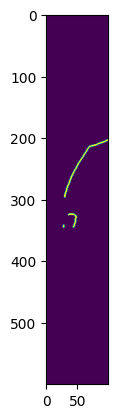

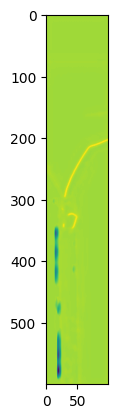

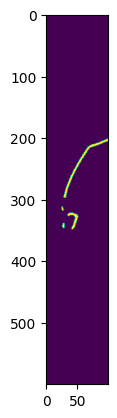

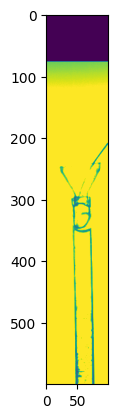

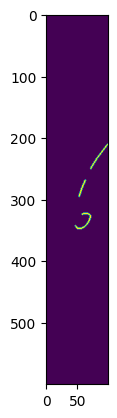

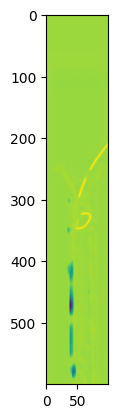

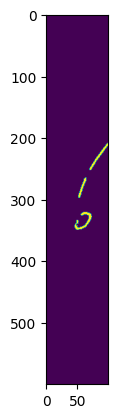

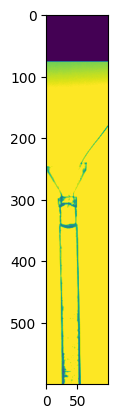

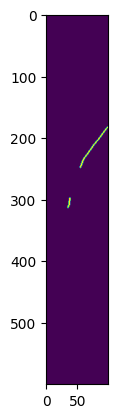

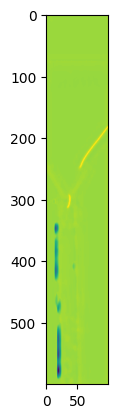

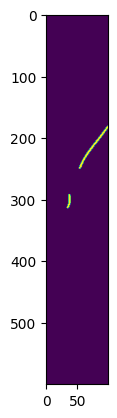

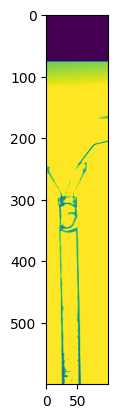

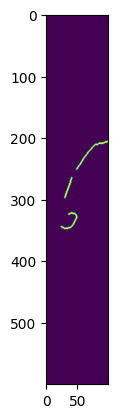

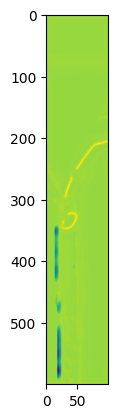

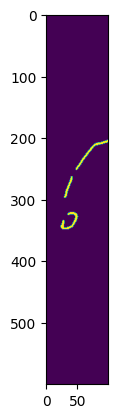

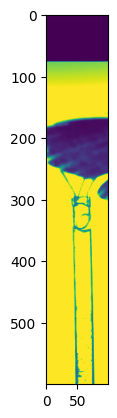

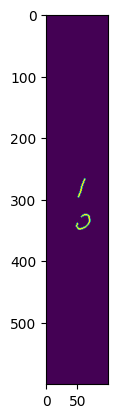

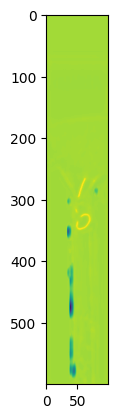

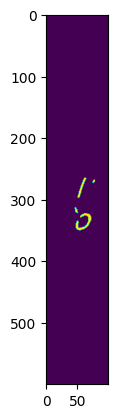

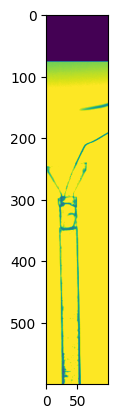

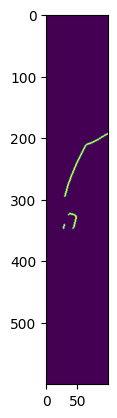

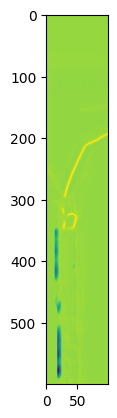

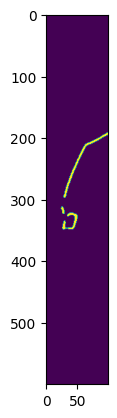

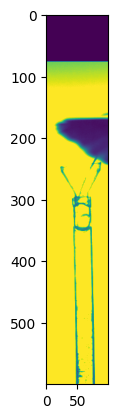

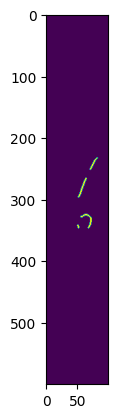

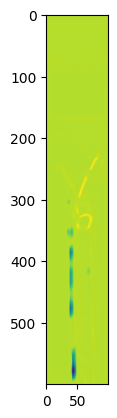

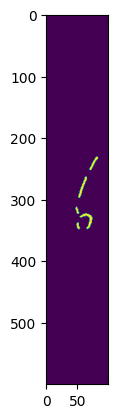

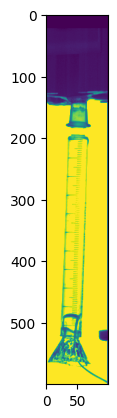

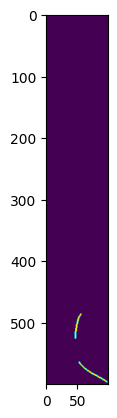

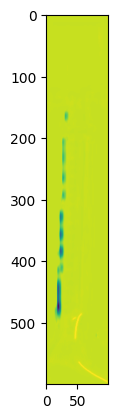

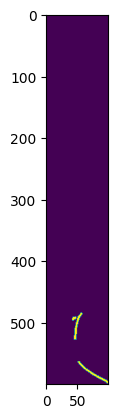

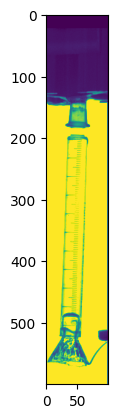

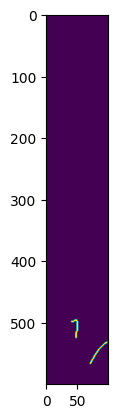

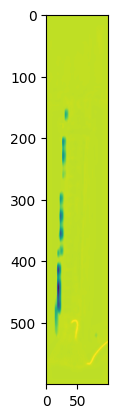

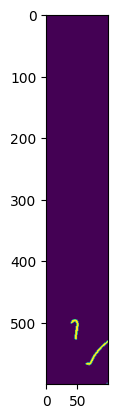

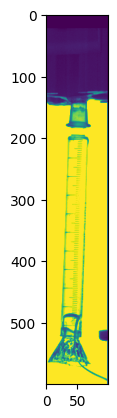

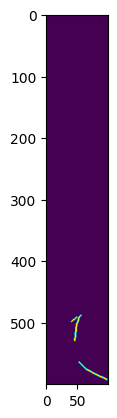

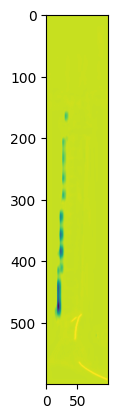

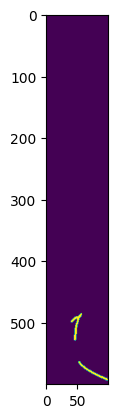

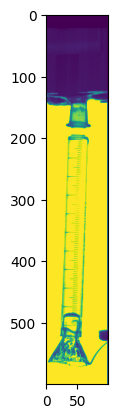

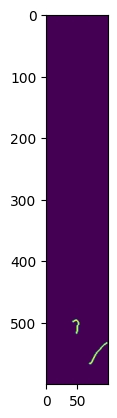

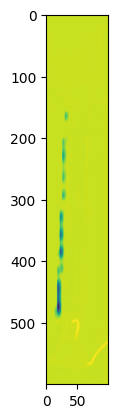

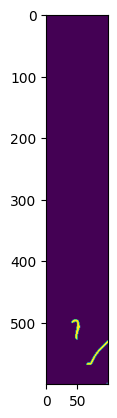

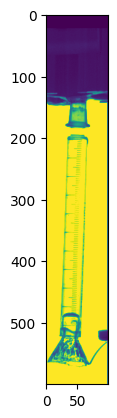

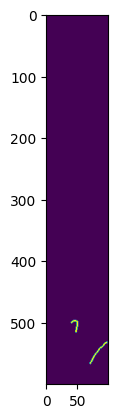

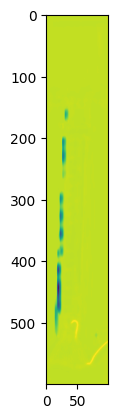

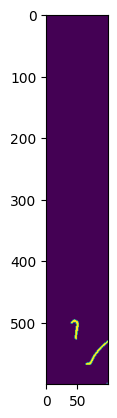

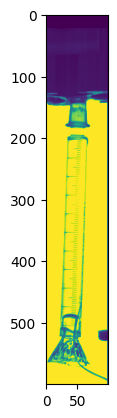

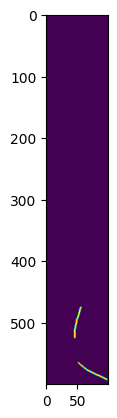

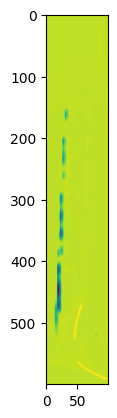

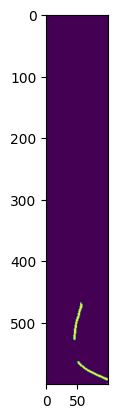

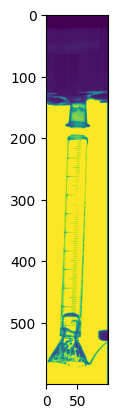

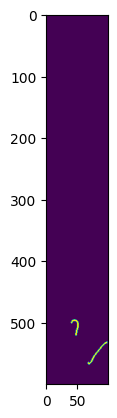

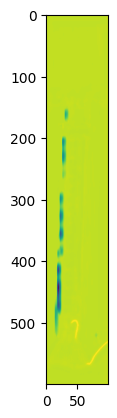

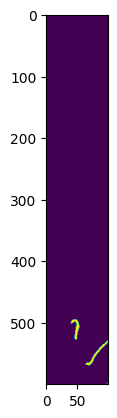

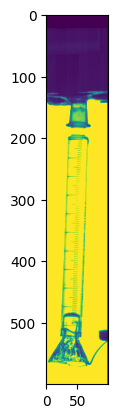

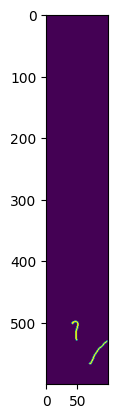

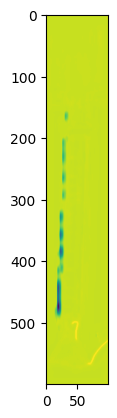

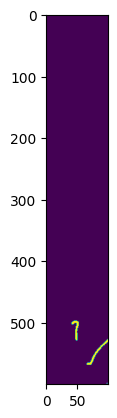

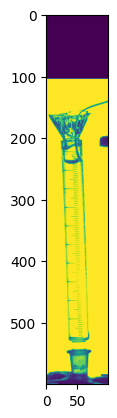

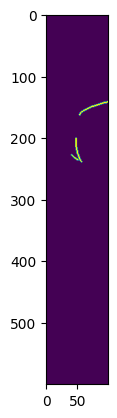

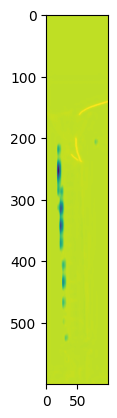

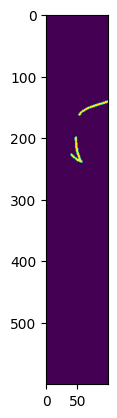

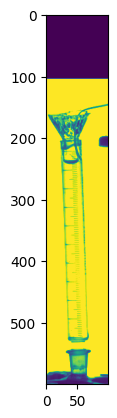

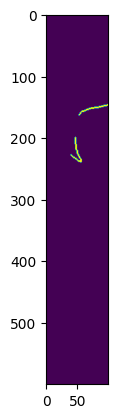

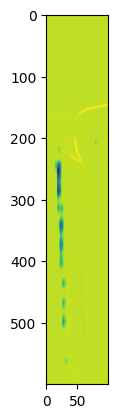

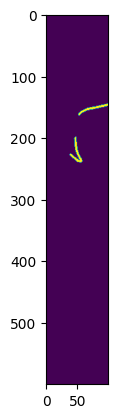

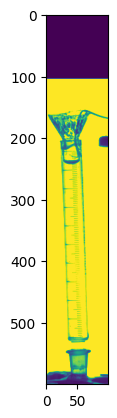

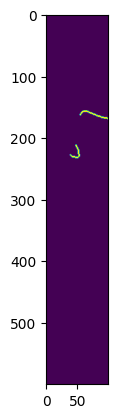

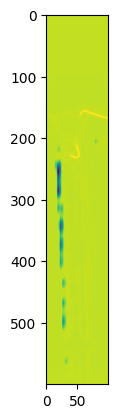

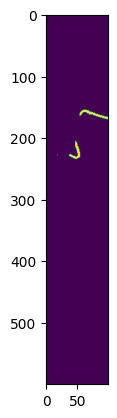

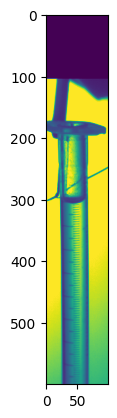

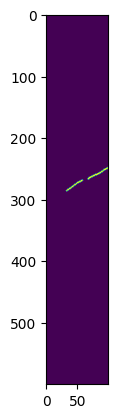

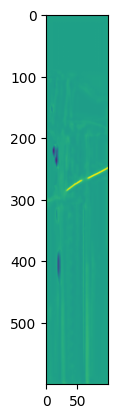

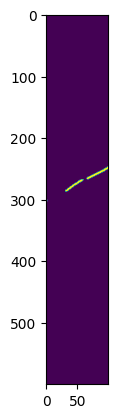

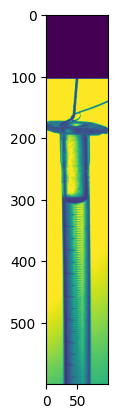

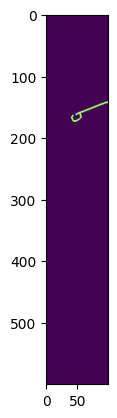

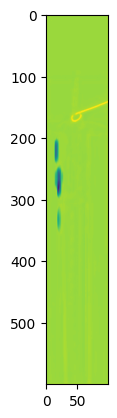

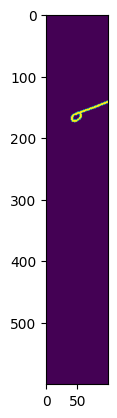

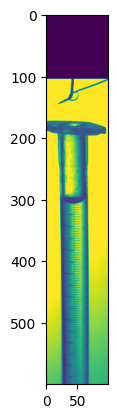

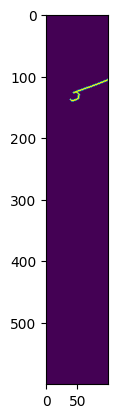

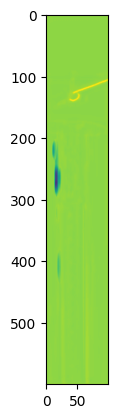

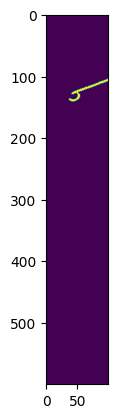

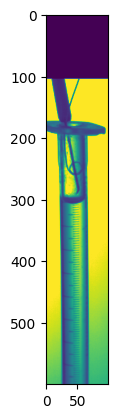

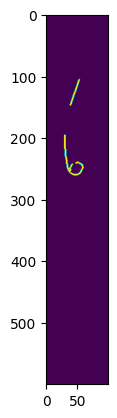

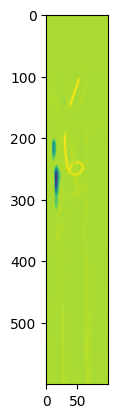

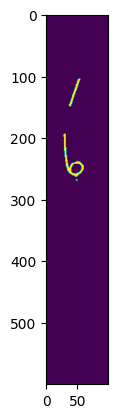

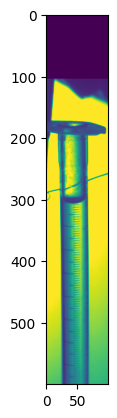

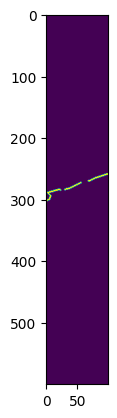

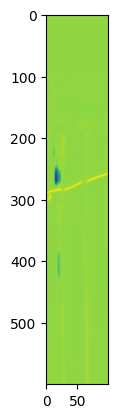

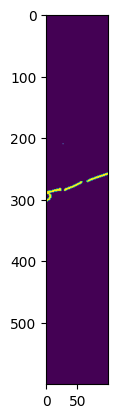

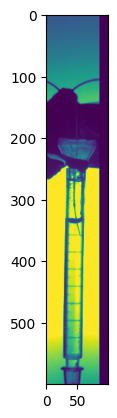

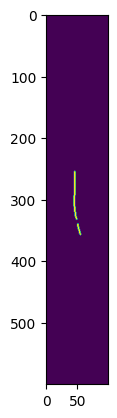

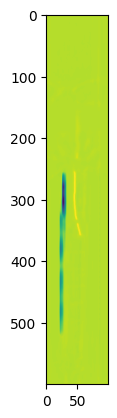

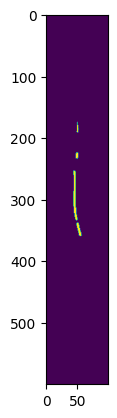

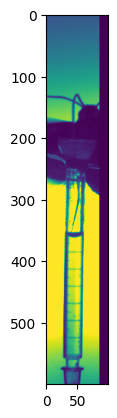

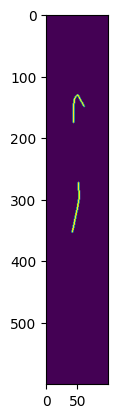

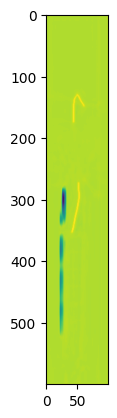

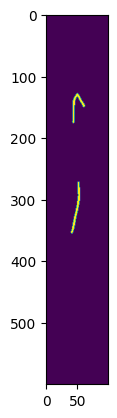

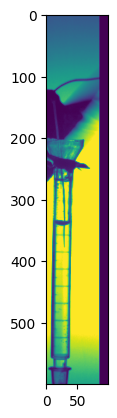

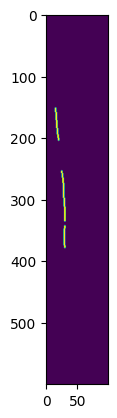

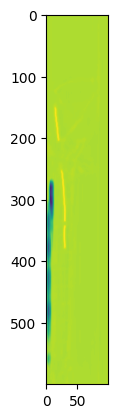

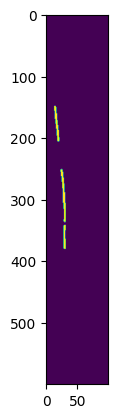

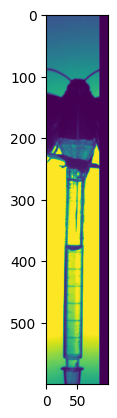

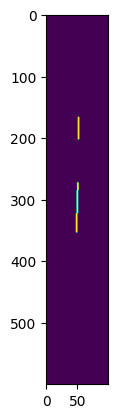

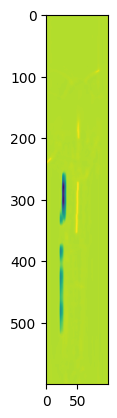

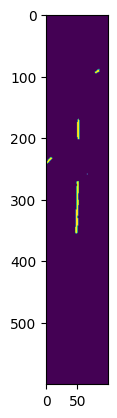

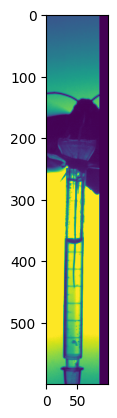

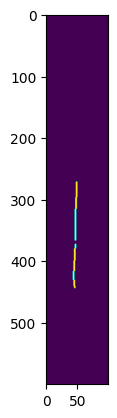

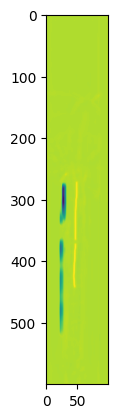

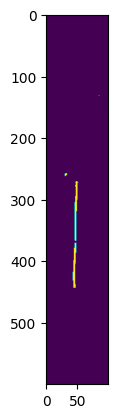

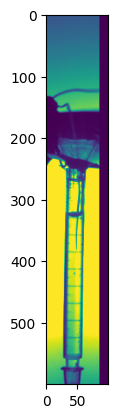

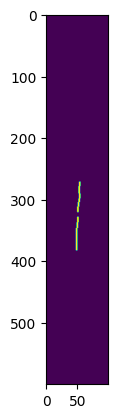

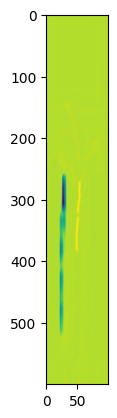

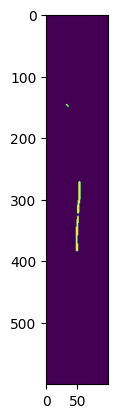

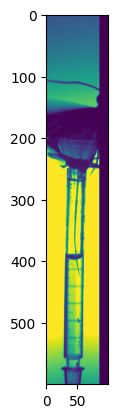

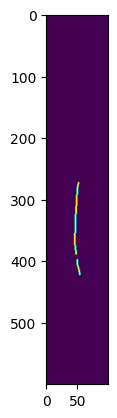

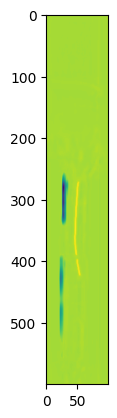

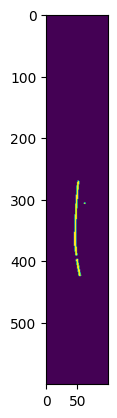

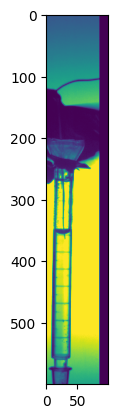

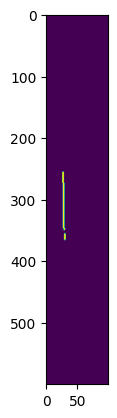

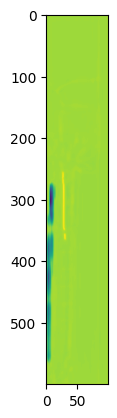

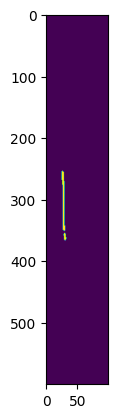

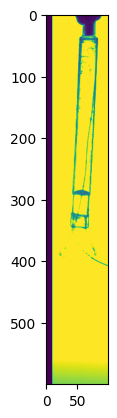

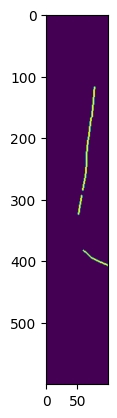

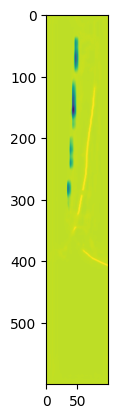

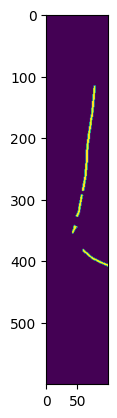

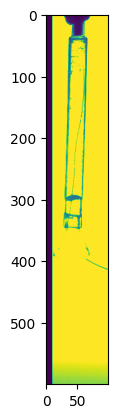

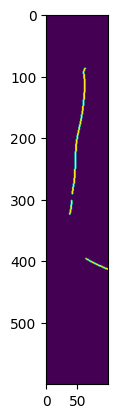

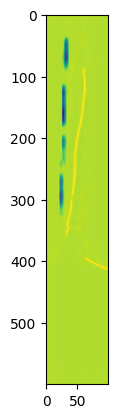

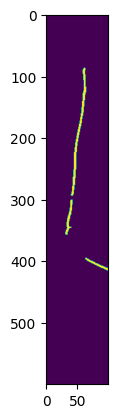

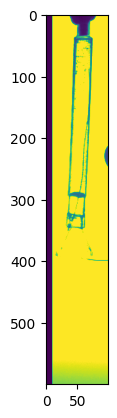

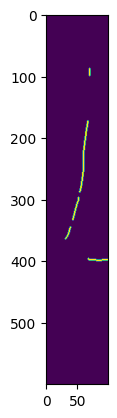

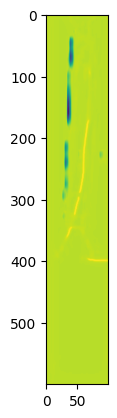

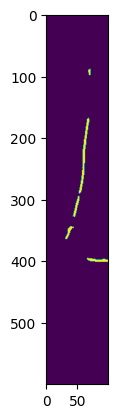

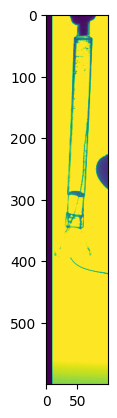

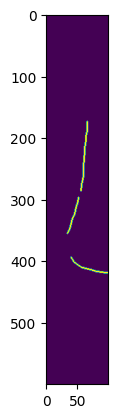

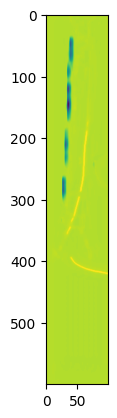

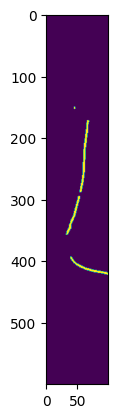

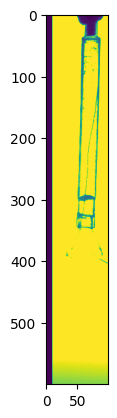

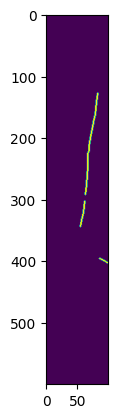

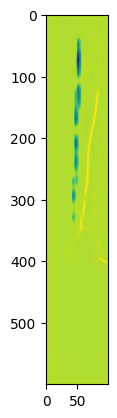

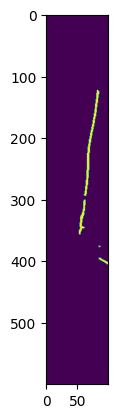

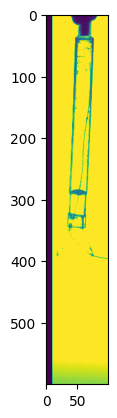

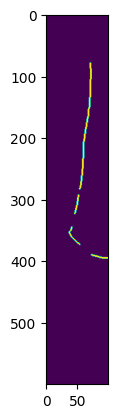

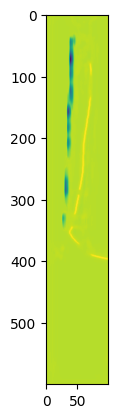

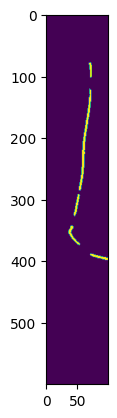

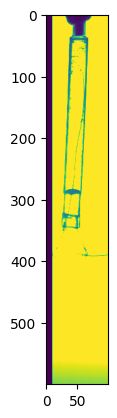

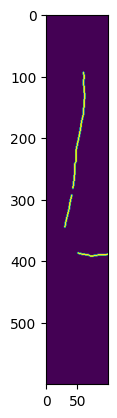

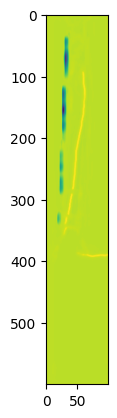

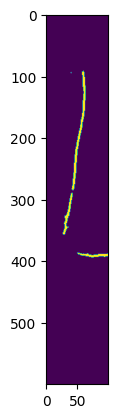

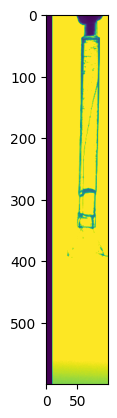

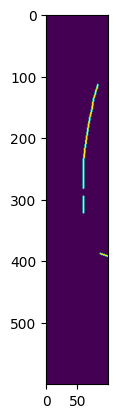

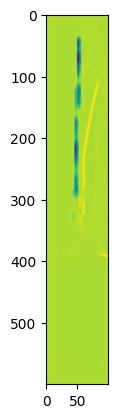

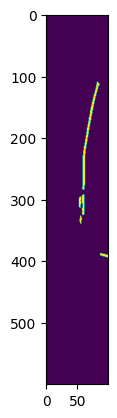

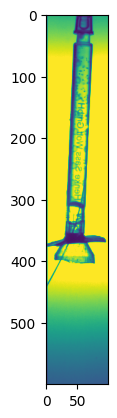

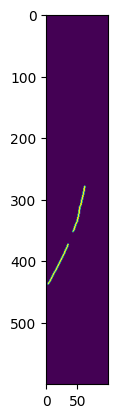

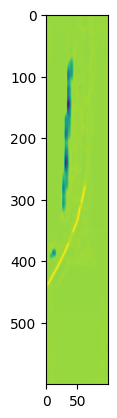

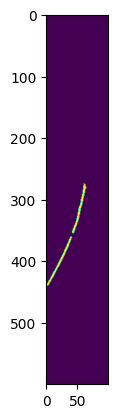

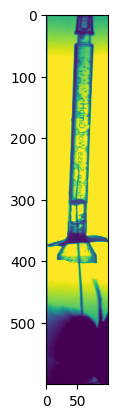

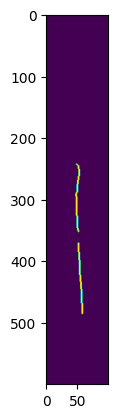

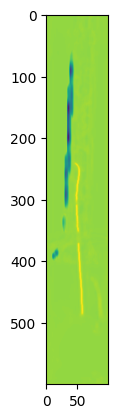

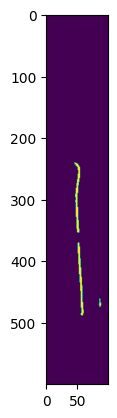

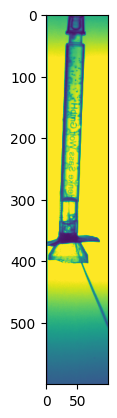

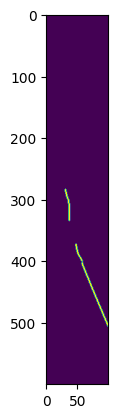

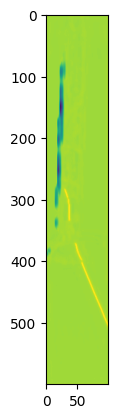

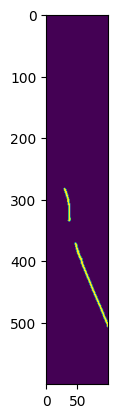

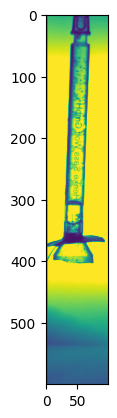

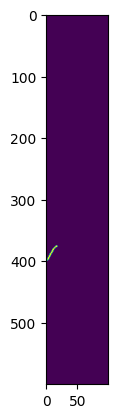

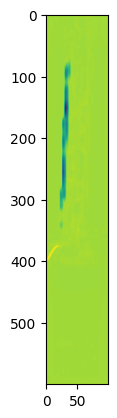

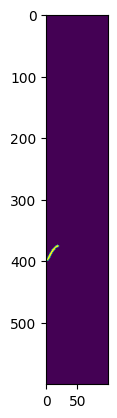

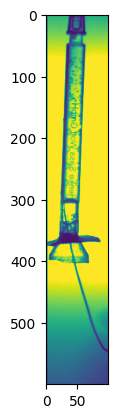

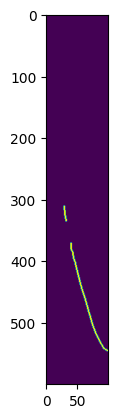

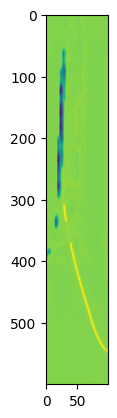

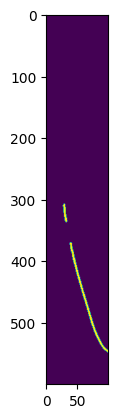

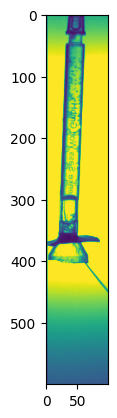

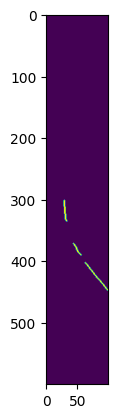

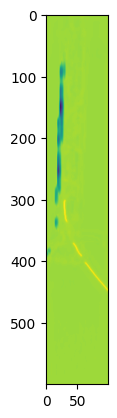

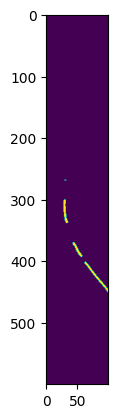

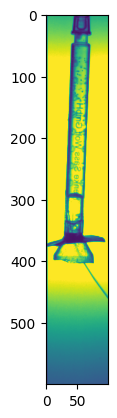

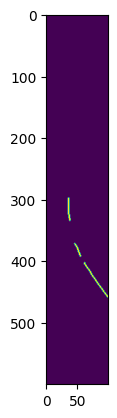

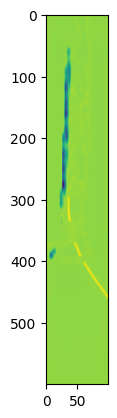

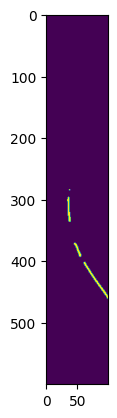

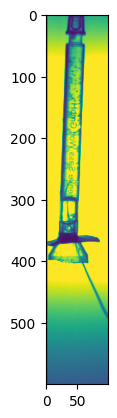

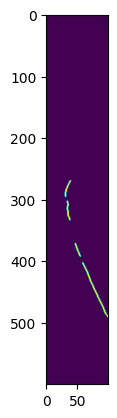

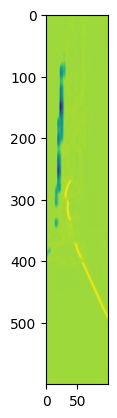

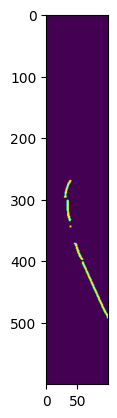

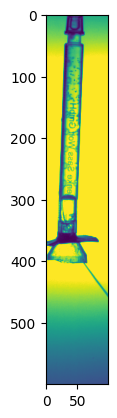

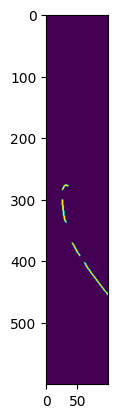

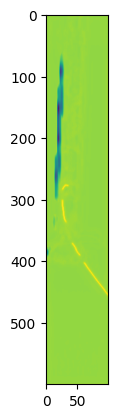

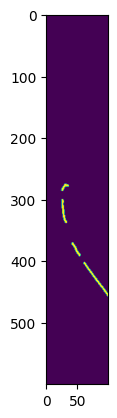

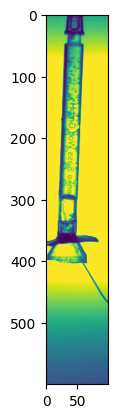

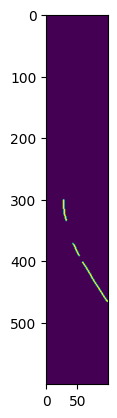

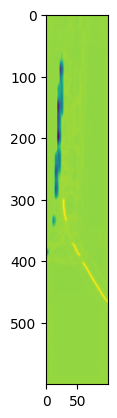

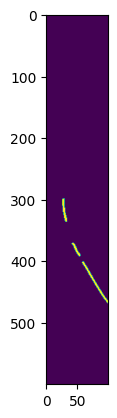

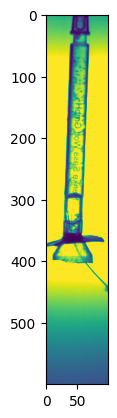

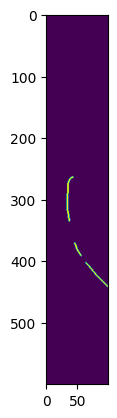

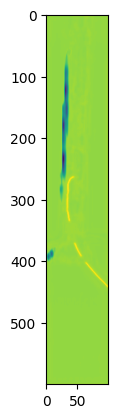

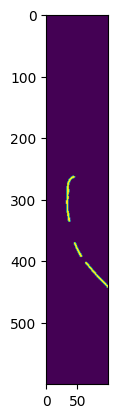

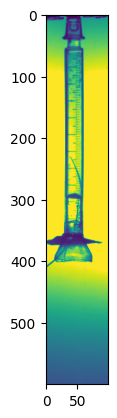

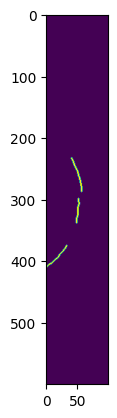

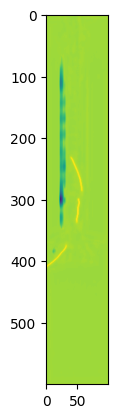

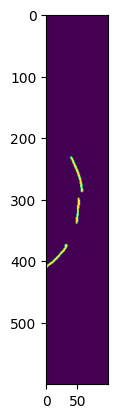

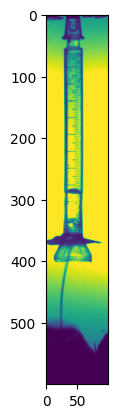

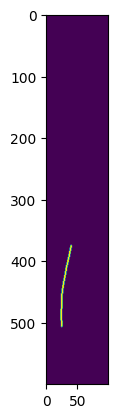

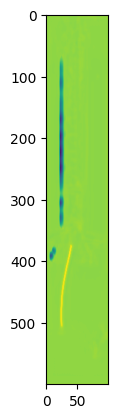

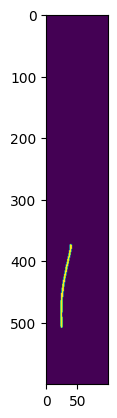

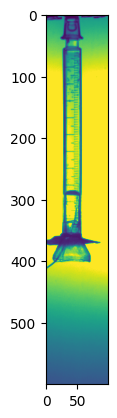

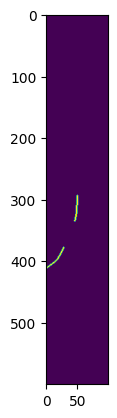

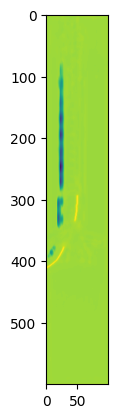

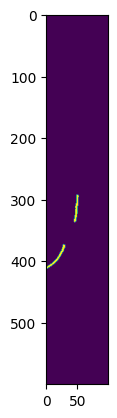

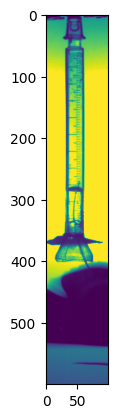

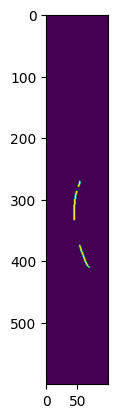

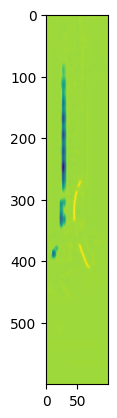

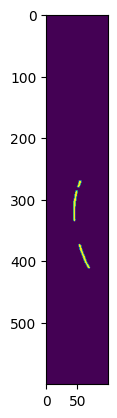

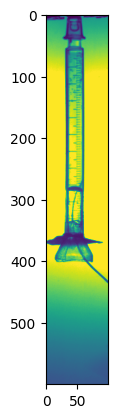

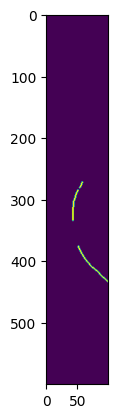

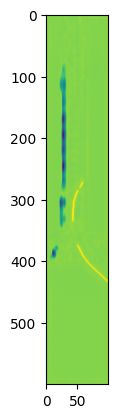

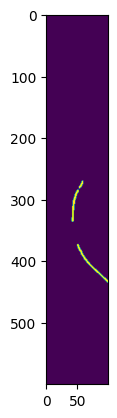

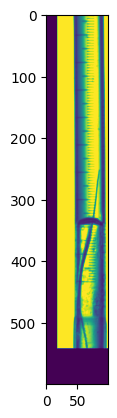

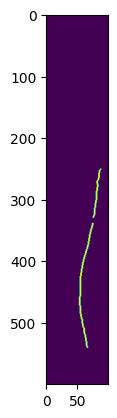

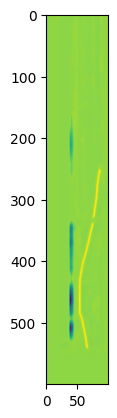

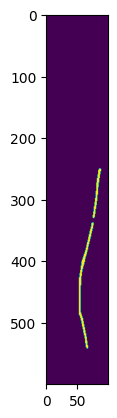

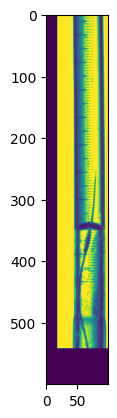

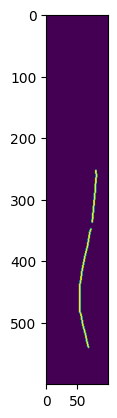

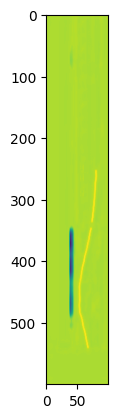

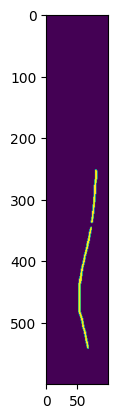

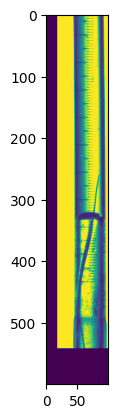

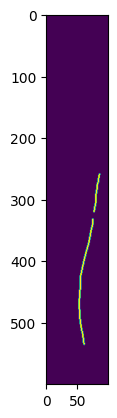

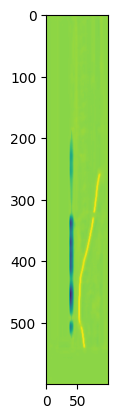

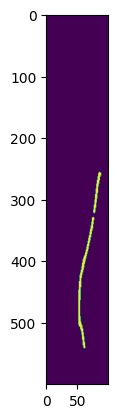

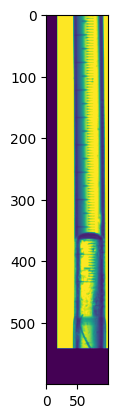

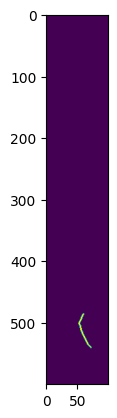

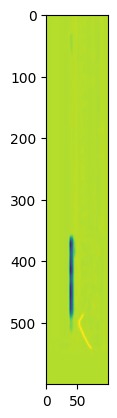

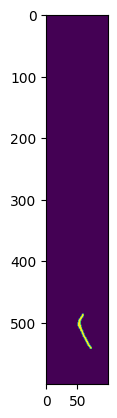

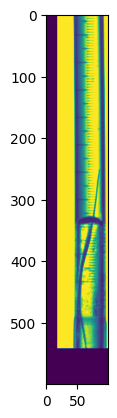

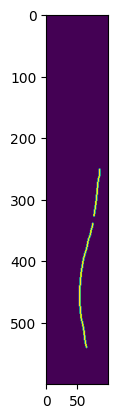

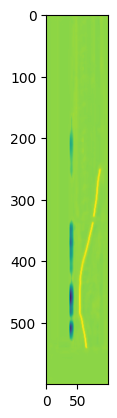

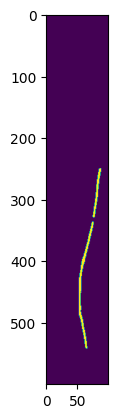

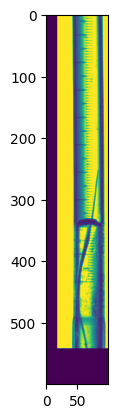

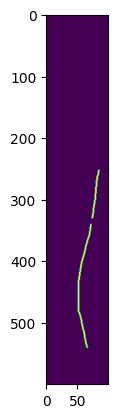

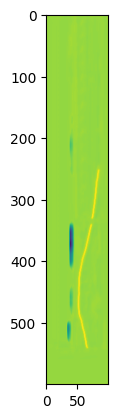

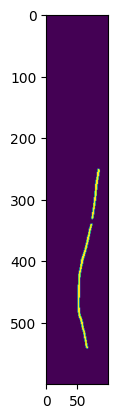

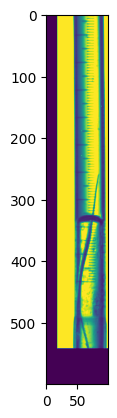

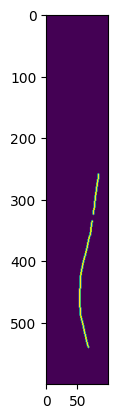

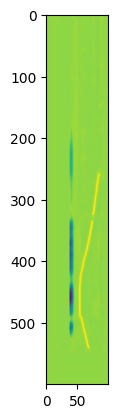

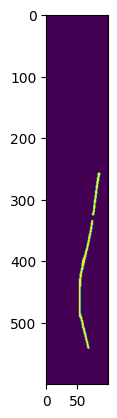

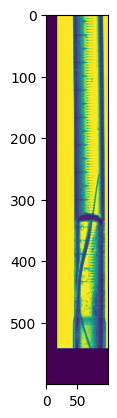

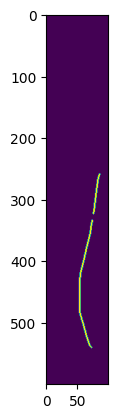

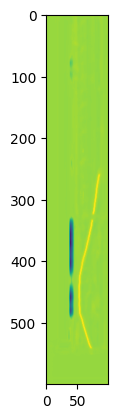

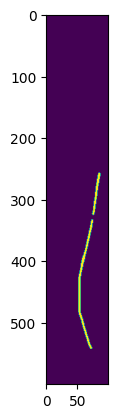

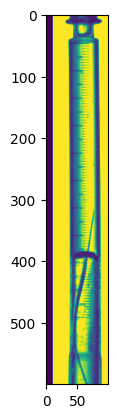

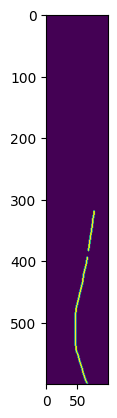

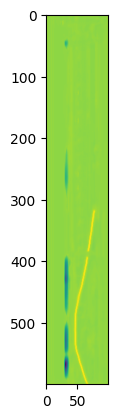

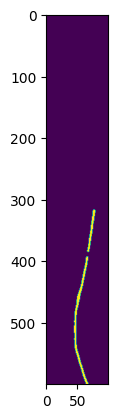

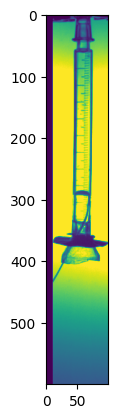

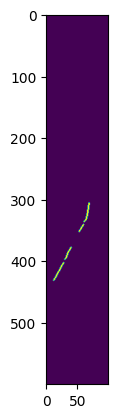

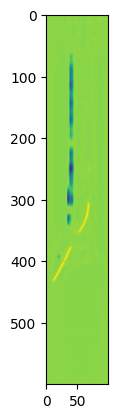

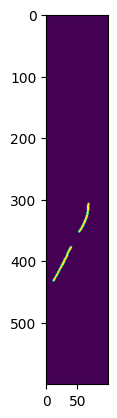

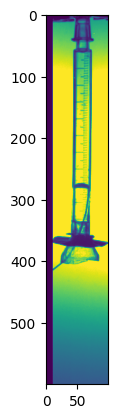

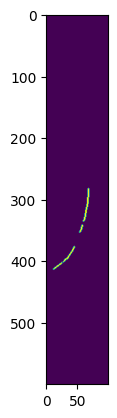

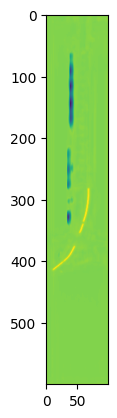

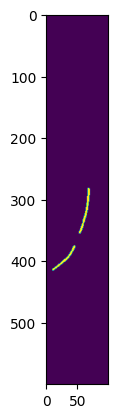

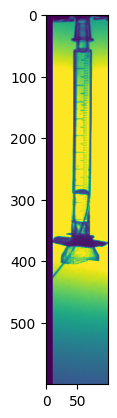

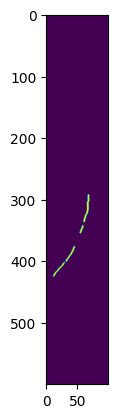

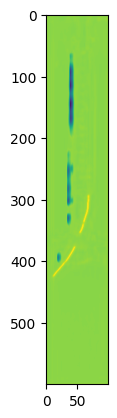

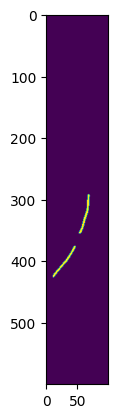

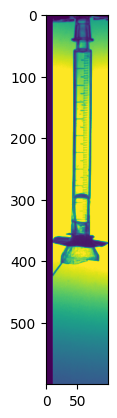

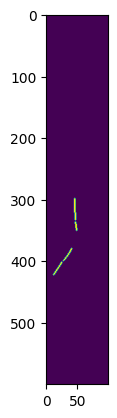

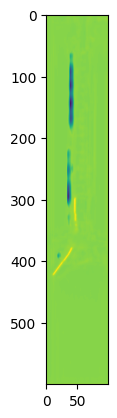

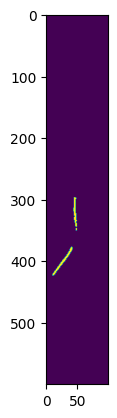

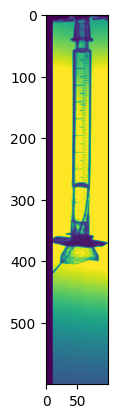

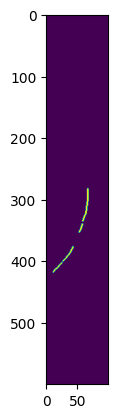

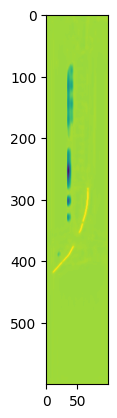

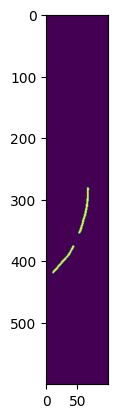

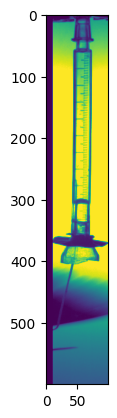

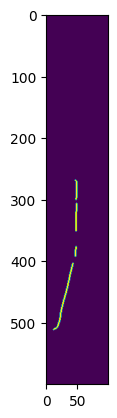

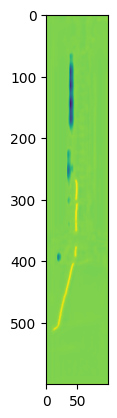

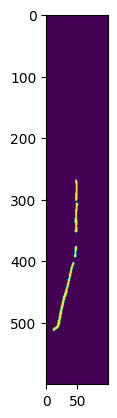

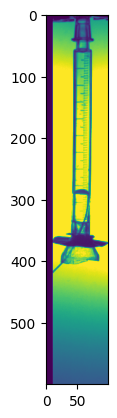

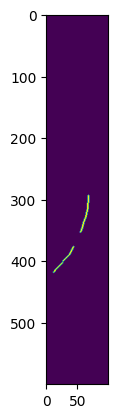

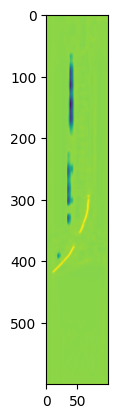

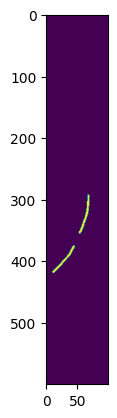

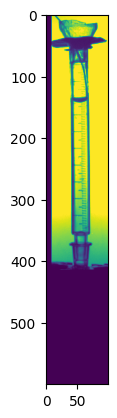

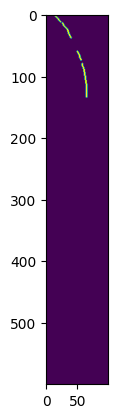

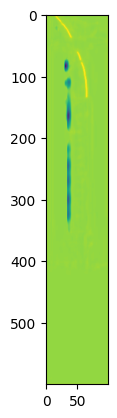

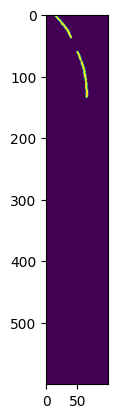

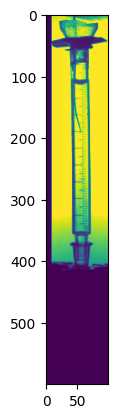

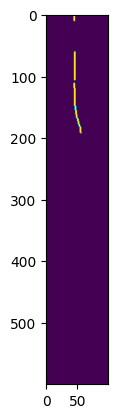

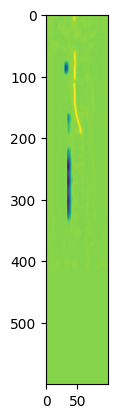

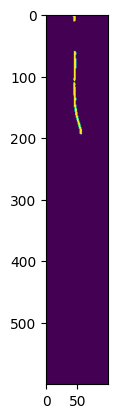

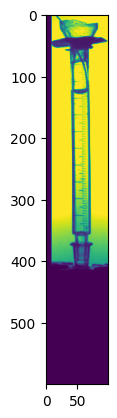

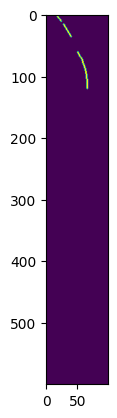

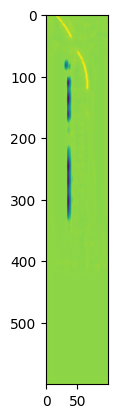

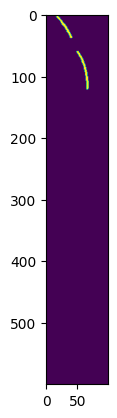

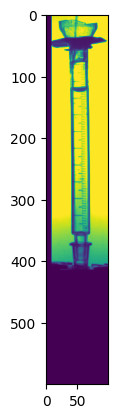

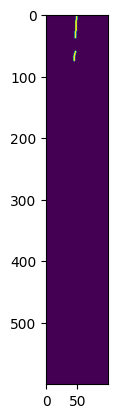

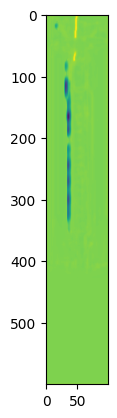

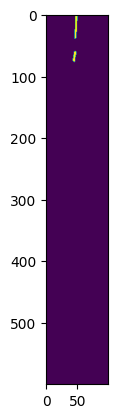

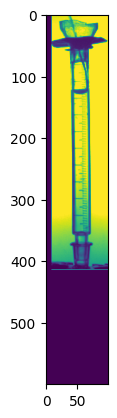

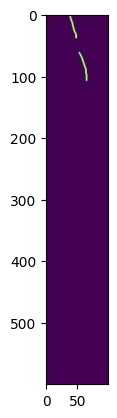

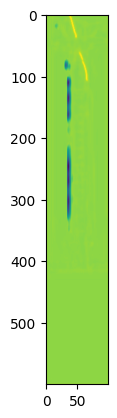

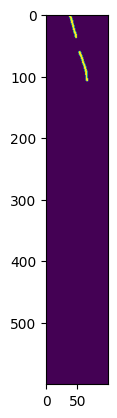

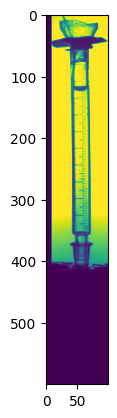

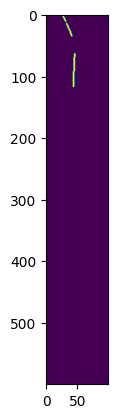

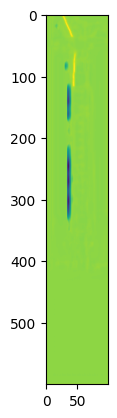

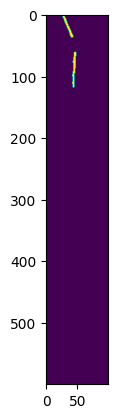

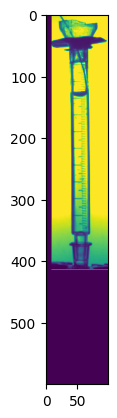

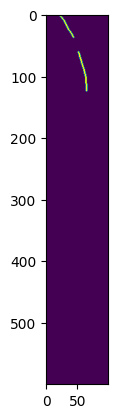

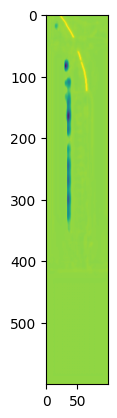

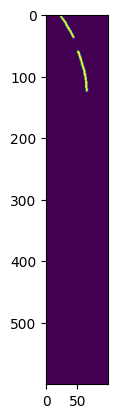

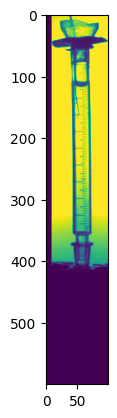

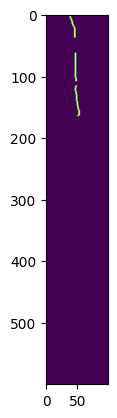

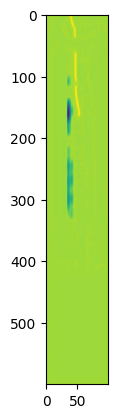

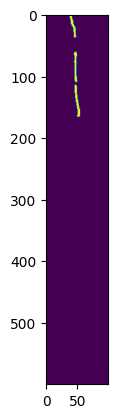

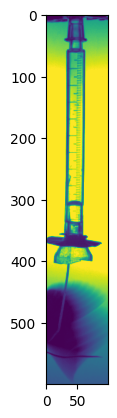

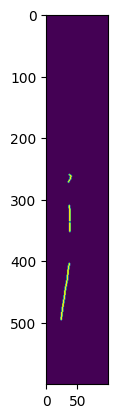

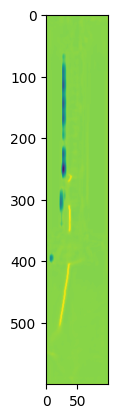

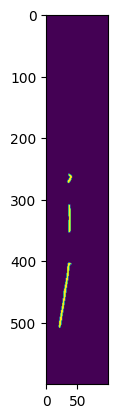

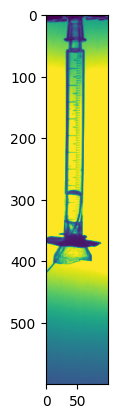

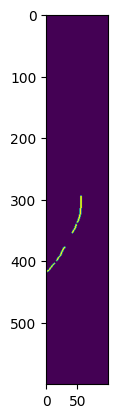

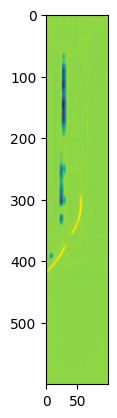

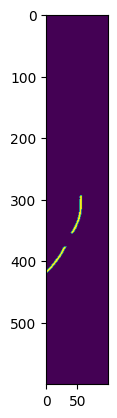

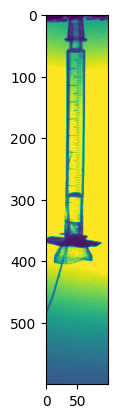

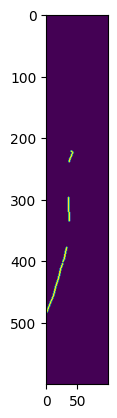

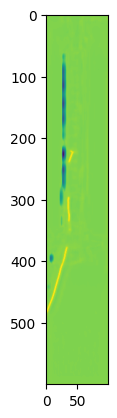

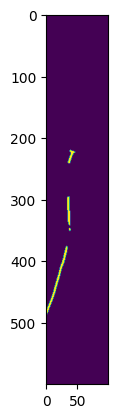

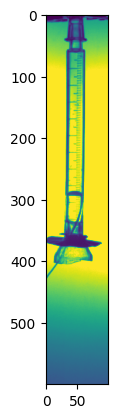

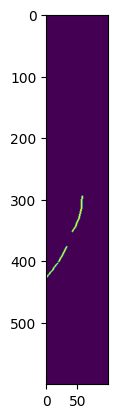

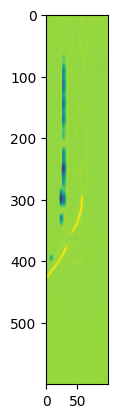

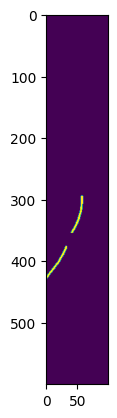

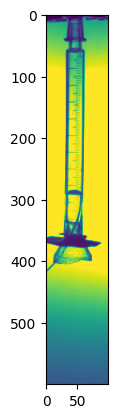

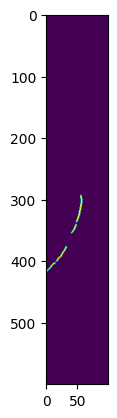

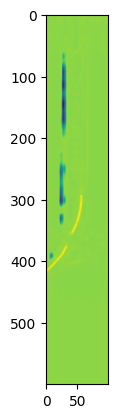

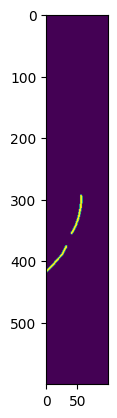

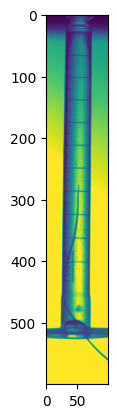

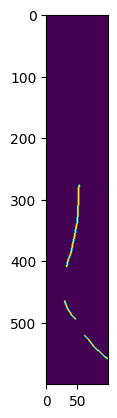

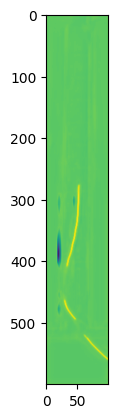

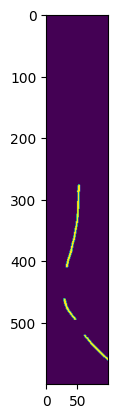

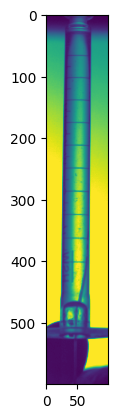

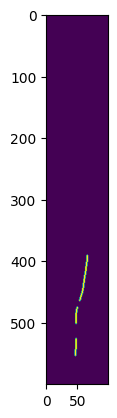

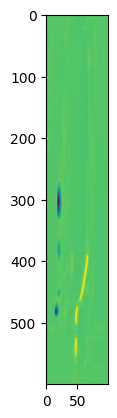

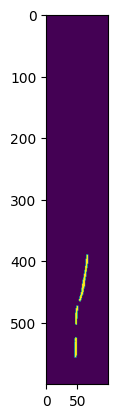

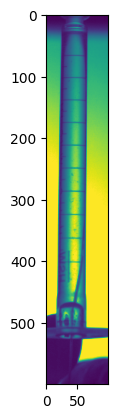

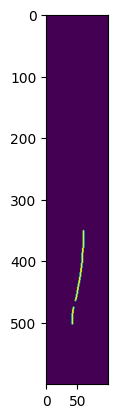

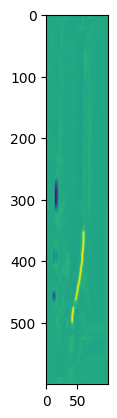

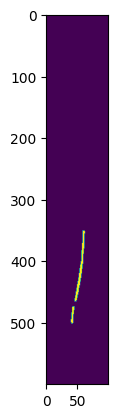

KeyboardInterrupt: 

In [29]:
#iou = keras.metrics.IoU(num_classes=2, target_class_ids=[1])
#tp = keras.metrics.TruePositives(thresholds=0)
#precision = keras.metrics.Precision(thresholds=0)
for batch_in, batch_out in test_sequence:
    results = model(batch_in)
    res = results.numpy()
    positive = res > 0
    for i in range(8):
        pyplot.imshow(batch_in[i,:,:,0])
        pyplot.show()
        pyplot.imshow(batch_out[i,:,:,0])
        pyplot.show()
        pyplot.imshow(res[i,:,:,0])
        pyplot.show()
        pyplot.imshow(positive[i,:,:,0])
        pyplot.show()

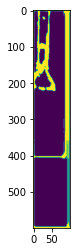

In [50]:
from skimage.io import imshow
pyplot.imshow(res[i,:,:,0] > )

In [32]:
keras.metrics.IoU?

In [ ]:
metric_ba = keras.metrics.

In [29]:
tp = tf.keras.metrics.TruePositives()

In [31]:
tp.update_state?

In [ ]:
prediction

In [31]:
m = model(a)

2023-04-22 07:29:27.146470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [32]:
n = m.numpy()

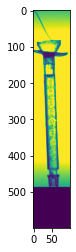

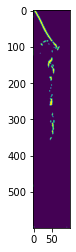

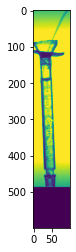

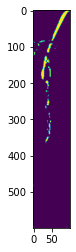

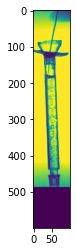

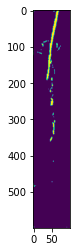

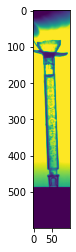

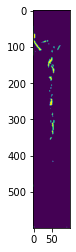

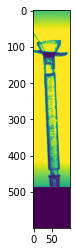

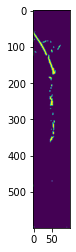

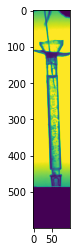

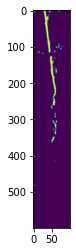

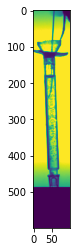

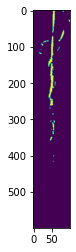

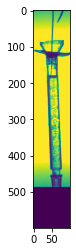

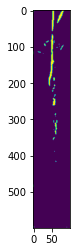

In [39]:
for i in range(8):
    pyplot.imshow(a[i,:,:,0])
    pyplot.show()
    pyplot.imshow(n[i,:,:,0] > 0)
    pyplot.show()

In [36]:
pyplot.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

In [3]:
pmodel1 = tf.keras.models.load_model("proboscis_model_1")

2023-04-23 13:16:22.855629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 13:16:24.760012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7994 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 2g.10gb, pci bus id: 0000:21:00.0, compute capability: 8.0


In [26]:
p = pmodel1.predict(r[10][0])

2023-04-23 13:18:23.776762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801


1/1 [==============================] - 12s 12s/step


In [27]:
type(p)

numpy.ndarray

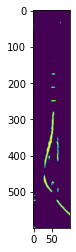

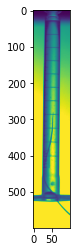

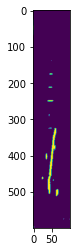

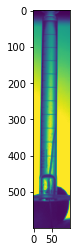

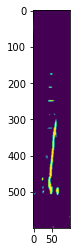

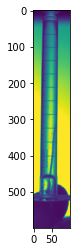

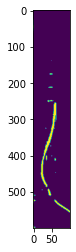

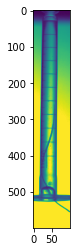

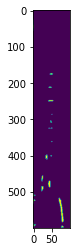

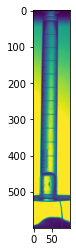

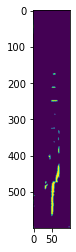

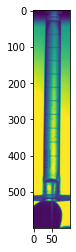

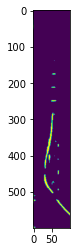

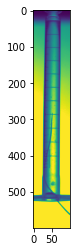

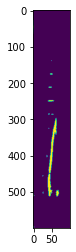

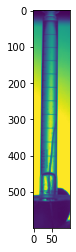

In [29]:
for i in range(8):
    pyplot.imshow(p[i,:,:,0] > 0)
    pyplot.show()
    pyplot.imshow(r[10][0][i,:,:,0])
    pyplot.show()

In [53]:
from skimage.feature import hog
from sklearn.svm import SVR

In [54]:
svm = SVR()

In [32]:
svm.fit?

In [33]:
i10, o10 = r[10]

In [34]:
i10a = i10[:,:,:,0]
o10a = o10[:,:,:,0]

In [44]:
ho, og = hog(o10a[0] * 255, visualize=True)

In [46]:
hi, ig = hog(i10a[0], visualize=True)

In [49]:
hog_in = np.array(list(map(hog, i10a)))
hog_out = np.array(list(map(hog, o10a * 255)))

In [50]:
hog_in.shape

(8, 59130)

In [51]:
hog_out.shape

(8, 59130)

In [58]:
pmodel1.fit(r, epochs=40)

Epoch 1/40


2023-04-23 13:41:56.844867: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x564e4ec2fad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-23 13:41:56.844900: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 2g.10gb, Compute Capability 8.0
2023-04-23 13:41:56.864580: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-23 13:41:56.965170: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOp

2816/2816 [==============================] - 527s 183ms/step - loss: 0.0051
Epoch 2/40
2816/2816 [==============================] - 514s 182ms/step - loss: 0.0049
Epoch 3/40
2816/2816 [==============================] - 515s 183ms/step - loss: 0.0050
Epoch 4/40
2816/2816 [==============================] - 514s 183ms/step - loss: 0.0040
Epoch 5/40
2816/2816 [==============================] - 515s 183ms/step - loss: 0.0044
Epoch 6/40
2816/2816 [==============================] - 514s 183ms/step - loss: 0.0037
Epoch 7/40
2816/2816 [==============================] - 514s 183ms/step - loss: 0.0037
Epoch 8/40
2816/2816 [==============================] - 515s 183ms/step - loss: 0.0032
Epoch 9/40
2816/2816 [==============================] - 515s 183ms/step - loss: 0.0039
Epoch 10/40
2816/2816 [==============================] - 514s 183ms/step - loss: 0.0033
Epoch 11/40
2816/2816 [==============================] - 514s 183ms/step - loss: 0.0036
Epoch 12/40
2816/2816 [=============================

In [59]:
pmodel1.save("overtrained_1")

INFO:tensorflow:Assets written to: overtrained_1/assets


INFO:tensorflow:Assets written to: overtrained_1/assets


In [60]:
q = pmodel1(r[0][0])
qq = q.numpy()

2023-04-23 19:42:39.375327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


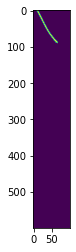

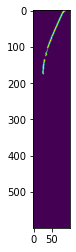

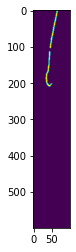

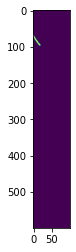

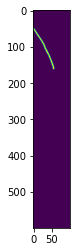

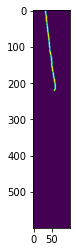

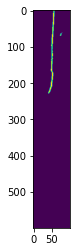

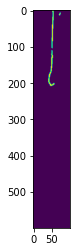

In [62]:
for i in range(8):
    pyplot.imshow(qq[i,:,:,0] > 0)
    pyplot.show()

In [66]:
inp = layers.Input(shape=[600,100,1])
res = layers.Rescaling(1.0/255)(inp)
#x = layers.Conv2D(filters=4, kernel_size=(3,3))(res)

skip1, enc1 = encoder(res, 64)
skip2, enc2 = encoder(enc1, 64 * 2)
#skip3, enc3 = encoder(enc2, 64 * 4)

conv_block = convolution_block(enc2, 64 * 4)

dec1 = decoder(conv_block, skip2, 64 * 2)
dec2 = decoder(dec1, skip1, 64)
#dec3 = decoder(dec2, skip1, 64)

f = layers.Flatten()(dec2)

#out = layers.Dense(1)(f)
out = layers.Conv2D(filters=1, kernel_size=(1,1))(dec2)

model2 = Model(inp, out)
model2.compile(loss=losses.BinaryCrossentropy(), optimizer=optimizers.Adam(use_ema=True))

In [67]:
model2.fit(r)

2816/2816 [==============================] - 523s 183ms/step - loss: 0.0381


In [ ]:
model2.fit(r, epochs=40)

Epoch 1/40
2816/2816 [==============================] - 515s 183ms/step - loss: 0.0287
Epoch 2/40
2816/2816 [==============================] - 514s 183ms/step - loss: 0.0315
Epoch 3/40
2816/2816 [==============================] - 515s 183ms/step - loss: 0.0229
Epoch 4/40
2816/2816 [==============================] - 514s 183ms/step - loss: 0.0208
Epoch 5/40
2816/2816 [==============================] - 514s 183ms/step - loss: 0.0202
Epoch 6/40
2519/2816 [=========================>....] - ETA: 54s - loss: 0.0164

In [ ]:
model2.save("momentum_trained_model_1")

In [13]:
from skimage import feature
from skimage import measure

In [1]:
input_feats = []
proboscis_present = []
for in_img, out_img in pairs:
    feats = feature.hog(in_img)
    input_feats.append(feats)
    present = 1 if out_img.sum() > 0 else -1
    proboscis_present.append(present)

NameError: name 'pairs' is not defined

In [15]:
-1 in proboscis_present

True

In [16]:
1 in proboscis_present

True

In [17]:
import random

In [18]:
from sklearn.svm import SVC

In [19]:
classifier = SVC(C=0.9)

In [20]:
classifier.fit(input_feats, proboscis_present)

SVC(C=0.9)

In [24]:
classifier.predict(input_feats[:373])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [2]:
from sklearn.feature_extraction.image import PatchExtractor

In [3]:
seed = 20240424
pe1 = PatchExtractor(patch_size=(20,20), max_patches=15000, random_state=seed)
pe2 = PatchExtractor(patch_size=(20,20), max_patches=15000, random_state=seed)
#pe1.fit(ins)
input_patches = pe1.transform(ins)
#pe2.fit(outs)
output_patches = pe2.transform(outs)

NameError: name 'ins' is not defined

In [23]:
import tensorflow as tf